In [1]:
?system
version

               _                           
platform       x86_64-pc-linux-gnu         
arch           x86_64                      
os             linux-gnu                   
system         x86_64, linux-gnu           
status                                     
major          3                           
minor          6.3                         
year           2020                        
month          02                          
day            29                          
svn rev        77875                       
language       R                           
version.string R version 3.6.3 (2020-02-29)
nickname       Holding the Windsock        



---

Analyze gene count data using Deseq2 

---



In [2]:
install.packages("rgl", repos = "http://cran.rstudio.com/")
install.packages("ConsRank", repos = "http://cran.rstudio.com/")
library("ConsRank")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘httpuv’, ‘xtable’, ‘sourcetools’, ‘fastmap’, ‘miniUI’, ‘webshot’, ‘shiny’, ‘manipulateWidget’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘XML’, ‘data.table’, ‘rlist’, ‘proxy’, ‘gtools’


Loading required package: rgl

Warning message in rgl.init(initValue, onlyNULL):
“RGL: unable to open X11 display”
Warning message:
“'rgl.init' failed, running with 'rgl.useNULL = TRUE'.”

Attaching package: ‘ConsRank’


The following object is masked from ‘package:base’:

    labels




In [3]:
system("add-apt-repository -y ppa:marutter/rrutter")
system("add-apt-repository -y ppa:marutter/c2d4u")
system("apt-get update")
system("apt install -y r-cran-rstan")

In [4]:
install.packages("ggplot2")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [5]:
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [6]:
BiocManager::install(version="3.9", ask=FALSE)

Bioconductor version 3.9 (BiocManager 1.30.10), R 3.6.3 (2020-02-29)

Installing package(s) 'BiocVersion'

Installing package(s) 'curl', 'DT', 'farver', 'ggplot2', 'isoband', 'jsonlite',
  'knitr', 'processx', 'rex', 'rmarkdown', 'rprojroot', 'tinytex', 'xfun'



In [7]:
BiocManager::install("DESeq2", version="3.9")

Bioconductor version 3.9 (BiocManager 1.30.10), R 3.6.3 (2020-02-29)

Installing package(s) 'DESeq2'

also installing the dependencies ‘bit’, ‘bitops’, ‘formatR’, ‘bit64’, ‘plogr’, ‘RCurl’, ‘GenomeInfoDbData’, ‘zlibbioc’, ‘lambda.r’, ‘futile.options’, ‘RSQLite’, ‘png’, ‘jpeg’, ‘GenomeInfoDb’, ‘XVector’, ‘DelayedArray’, ‘futile.logger’, ‘snow’, ‘AnnotationDbi’, ‘annotate’, ‘Formula’, ‘latticeExtra’, ‘acepack’, ‘htmlTable’, ‘viridis’, ‘S4Vectors’, ‘IRanges’, ‘GenomicRanges’, ‘SummarizedExperiment’, ‘BiocGenerics’, ‘Biobase’, ‘BiocParallel’, ‘genefilter’, ‘locfit’, ‘geneplotter’, ‘Hmisc’, ‘RcppArmadillo’


Old packages: 'curl', 'DT', 'farver', 'ggplot2', 'isoband', 'jsonlite',
  'knitr', 'processx', 'rex', 'rmarkdown', 'rprojroot', 'tinytex', 'xfun',
  'nlme', 'survival'



In [ ]:
# Download the Data

In [19]:
countsName <- "https://bioconnector.github.io/workshops/data/airway_scaledcounts.csv"
download.file(countsName, destfile = "airway_scaledcounts.csv", method = "auto")

countData <- read.csv('airway_scaledcounts.csv', header = TRUE, sep = ",")
head(countData)

,ensgene,SRR1039508,SRR1039509,SRR1039512,SRR1039513,SRR1039516,SRR1039517,SRR1039520,SRR1039521
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ENSG00000000003,723,486,904,445,1170,1097,806,604
2,ENSG00000000005,0,0,0,0,0,0,0,0
3,ENSG00000000419,467,523,616,371,582,781,417,509
4,ENSG00000000457,347,258,364,237,318,447,330,324
5,ENSG00000000460,96,81,73,66,118,94,102,74
6,ENSG00000000938,0,0,1,0,2,0,0,0


In [20]:
metaDataName <- "https://bioconnector.github.io/workshops/data/airway_metadata.csv"
download.file(metaDataName, destfile = "airway_metadata.csv", method = "auto")
metaData <- read.csv('airway_metadata.csv', header = TRUE, sep = ",")
metaData


# metadata matrix: an matrix in the form of pandas dataframe, 
# see DESeq2 manual, samplenames as rownames following treatment type (A,B)
#     sampleA1        A
#     sampleA2        A
#     sampleB1        B
#     sampleB2        B

id,dex,celltype,geo_id
<fct>,<fct>,<fct>,<fct>
SRR1039508,control,N61311,GSM1275862
SRR1039509,treated,N61311,GSM1275863
SRR1039512,control,N052611,GSM1275866
SRR1039513,treated,N052611,GSM1275867
SRR1039516,control,N080611,GSM1275870
SRR1039517,treated,N080611,GSM1275871
SRR1039520,control,N061011,GSM1275874
SRR1039521,treated,N061011,GSM1275875


**Differential analysis Calculation with Salmon data using DESEQ2**

Construct DESEQDataSet Object


In [21]:
library(ggplot2)
library( "DESeq2" )

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min



Attaching package: ‘S4Vectors’


The

In [22]:
dds <- DESeqDataSetFromMatrix(countData=countData, 
                              colData=metaData, 
                              design=~dex, tidy = TRUE)

converting counts to integer mode



In [23]:
#Design specifies how the counts from each gene depend on our variables in the metadata
#For this dataset the factor we care about is our treatment status (dex)
#tidy=TRUE argument, which tells DESeq2 to output the results table with rownames as a first #column called 'row.

#let's see what this object looks like
dds

class: DESeqDataSet 
dim: 38694 8 
metadata(1): version
assays(1): counts
rownames(38694): ENSG00000000003 ENSG00000000005 ... ENSG00000283120
  ENSG00000283123
rowData names(0):
colnames(8): SRR1039508 SRR1039509 ... SRR1039520 SRR1039521
colData names(4): id dex celltype geo_id

Run DESEQ function

In [47]:
dds <- DESeq(dds)
#estimateSizeFactors
#This calculates the relative library depth of each sample 

#estimateDispersions
#estimates the dispersion of counts for each gene 

#nbinomWaldTest
#calculates the significance of coefficients in a Negative Binomial GLM using the size and dispersion outputs

using pre-existing size factors

estimating dispersions

found already estimated dispersions, replacing these

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



Results Table

In [61]:
res <- results(dds, tidy=TRUE)
head(res)

,row,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ENSG00000000003,747.1941954,-0.35070296,0.1682421,-2.0845139,0.03711345,0.1630172
2,ENSG00000000005,0.0000000,NA,NA,NA,NA,NA
3,ENSG00000000419,520.1341601,0.20610728,0.1010415,2.0398279,0.04136747,0.1759366
4,ENSG00000000457,322.6648439,0.02452701,0.1451339,0.1689958,0.86579996,0.9616825
5,ENSG00000000460,87.6826252,-0.14714263,0.2569954,-0.5725496,0.56694971,0.8158052
6,ENSG00000000938,0.3191666,-1.73228897,3.4936010,-0.4958463,0.62000288,NA


Summary of differential gene expression

In [62]:
summary(res)

     row               baseMean        log2FoldChange       lfcSE      
 Length:38694       Min.   :     0.0   Min.   :-6.030   Min.   :0.057  
 Class :character   1st Qu.:     0.0   1st Qu.:-0.425   1st Qu.:0.174  
 Mode  :character   Median :     1.1   Median :-0.009   Median :0.445  
                    Mean   :   570.2   Mean   :-0.011   Mean   :1.136  
                    3rd Qu.:   201.8   3rd Qu.: 0.306   3rd Qu.:1.848  
                    Max.   :329280.4   Max.   : 8.906   Max.   :3.534  
                                       NA's   :13436    NA's   :13436  
      stat             pvalue           padj      
 Min.   :-15.898   Min.   :0.000   Min.   :0.000  
 1st Qu.: -0.643   1st Qu.:0.168   1st Qu.:0.203  
 Median : -0.027   Median :0.533   Median :0.606  
 Mean   :  0.045   Mean   :0.495   Mean   :0.539  
 3rd Qu.:  0.593   3rd Qu.:0.800   3rd Qu.:0.866  
 Max.   : 18.422   Max.   :1.000   Max.   :1.000  
 NA's   :13436     NA's   :13578   NA's   :23549  

Sort summary list by p-value

In [63]:
res <- res[order(res$padj),]
head(res)

,row,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
9541,ENSG00000152583,954.7709,4.368359,0.23713055,18.42175,8.792137e-76,1.331569e-71
14524,ENSG00000179094,743.2527,2.863889,0.17556588,16.31233,8.065679e-60,6.107735e-56
4586,ENSG00000116584,2277.9135,-1.034700,0.06508256,-15.89828,6.513169e-57,3.288065e-53
16731,ENSG00000189221,2383.7537,3.341544,0.21240908,15.73164,9.179598e-56,3.475625e-52
5010,ENSG00000120129,3440.7038,2.965211,0.20369778,14.55691,5.278831e-48,1.598958e-44
9039,ENSG00000148175,13493.9204,1.427168,0.10038114,14.21749,7.136249e-46,1.801308e-42


Plot Counts

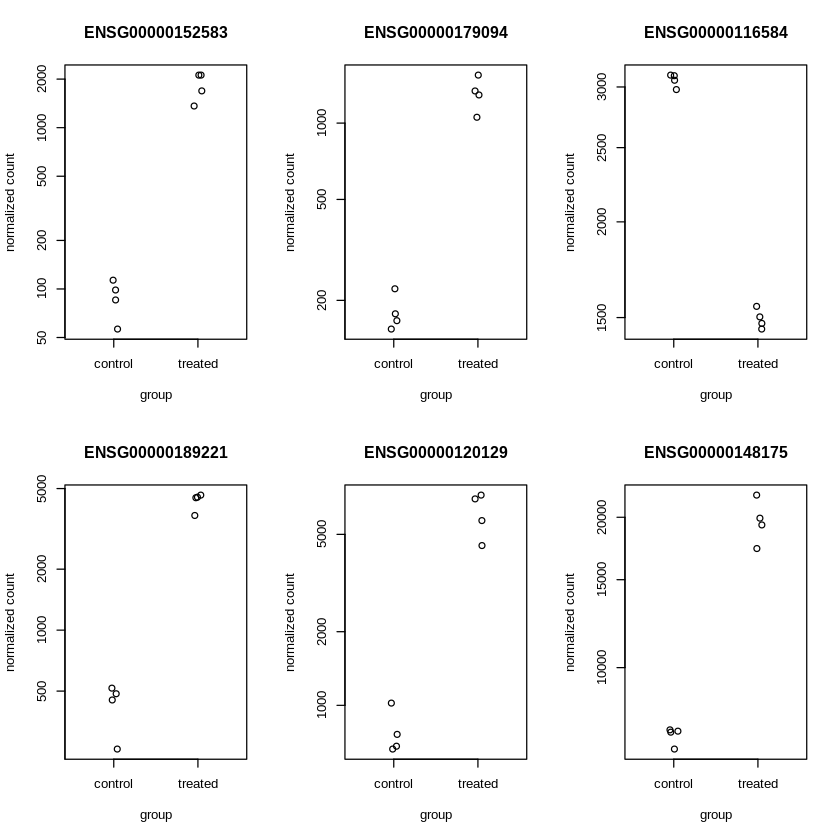

In [33]:
#we can use plotCounts fxn to compare the normalized counts
#between treated and control groups for our top 6 genes
par(mfrow=c(2,3))

plotCounts(dds, gene="ENSG00000152583", intgroup="dex")
plotCounts(dds, gene="ENSG00000179094", intgroup="dex")
plotCounts(dds, gene="ENSG00000116584", intgroup="dex")
plotCounts(dds, gene="ENSG00000189221", intgroup="dex")
plotCounts(dds, gene="ENSG00000120129", intgroup="dex")
plotCounts(dds, gene="ENSG00000148175", intgroup="dex")
#Next steps in exploring these data...BLAST to database to find associated gene function

Volcano Plot

In [35]:
library(repr)
options(repr.plot.width=10, repr.plot.height=7) 

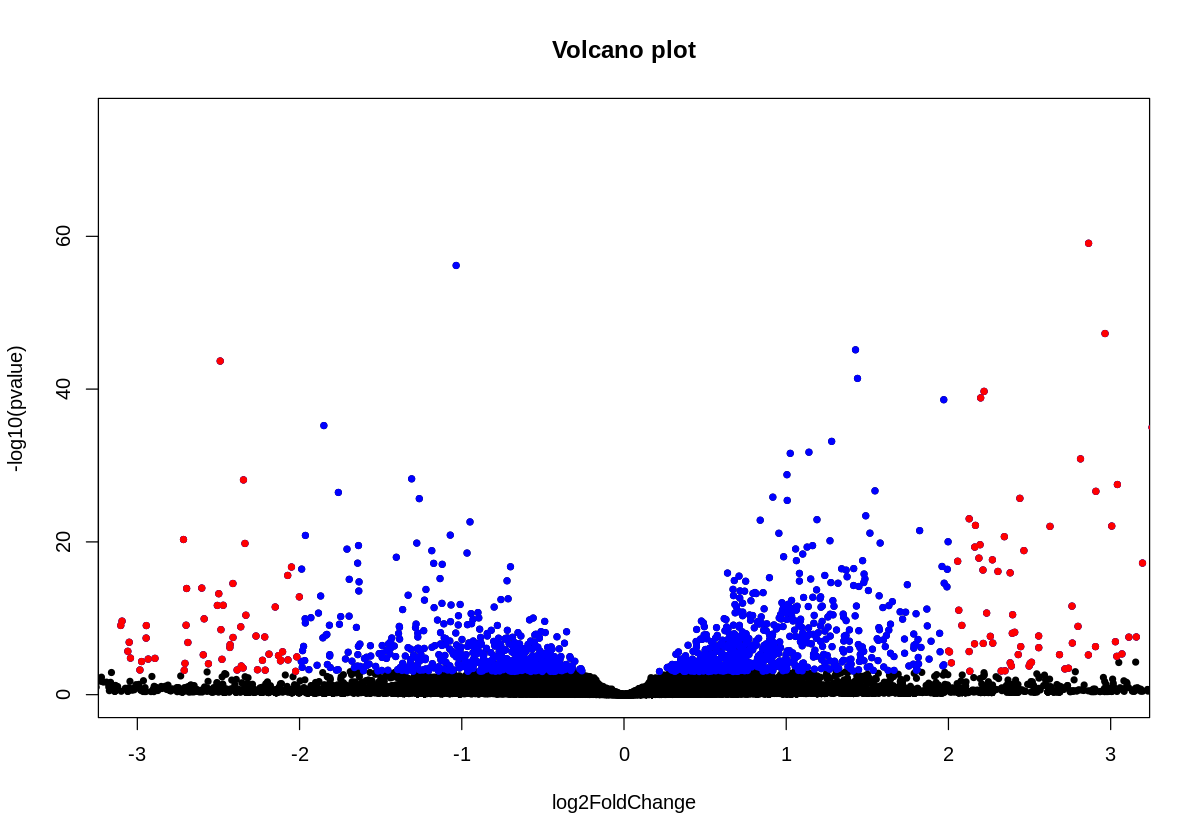

In [36]:
#reset par
par(mfrow=c(1,1))
# Make a basic volcano plot
with(res, plot(log2FoldChange, -log10(pvalue), pch=20, main="Volcano plot", xlim=c(-3,3)))

# Add colored points: blue if padj<0.01, red if log2FC>1 and padj<0.05)
with(subset(res, padj<.01 ), points(log2FoldChange, -log10(pvalue), pch=20, col="blue"))
with(subset(res, padj<.01 & abs(log2FoldChange)>2), points(log2FoldChange, -log10(pvalue), pch=20, col="red"))


In [37]:
#First we need to transform the raw count data
#vst function will perform variance stabilizing transformation

vsdata <- vst(dds, blind=FALSE)

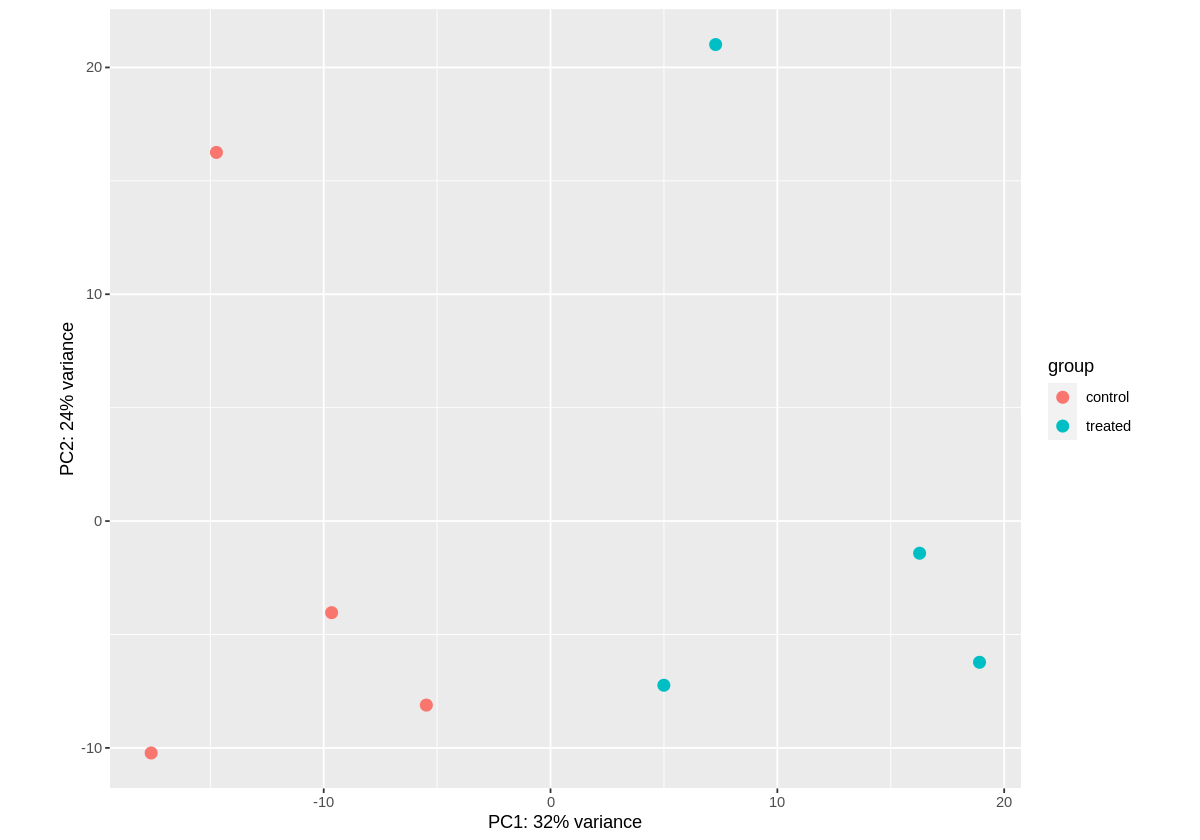

In [38]:
plotPCA(vsdata, intgroup="dex")
#using the DESEQ2 plotPCA fxn we can look at how our samples group by treatment
